In [1]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
def load_average_scores():
    rsivl = "/ptmp/tshen/shared/RSIVL/labels.xls"
    visc = "/ptmp/tshen/shared/VISC/VISC-C/labels.csv"

    labels = {}
    labels['rsivl'] = pd.read_excel(rsivl)
    labels['rsivl'].rename(columns={'subjective scores': 'complexity', 'Unnamed: 0': 'filename'}, inplace=True)
    labels['rsivl']['filename'] = labels['rsivl']['filename'] + ".bmp"
    labels['visc'] = pd.read_csv(visc)
    labels['visc'].rename(columns={'score': 'complexity', 'image': 'filename'}, inplace=True)

    for k in labels.keys():
        assert labels[k][['filename', 'complexity']].isnull().values.any() == False

    return labels

In [3]:
def load_predictions(folder="../out/2023July20", filenames=['4points', '8points', '16points', '32points', '64points']):
    rsivl = "{}/RSIVL".format(folder)
    visc = "{}/VISC".format(folder)

    preds = {}
    
    for v, n in zip([rsivl, visc], ["rsivl", "visc"]):
        preds_dataset = []
        single_file_len = 0

        for f in filenames:
            df = pd.read_csv("{}/{}.csv".format(v, f), names=["filename", f], header=None)
            preds_dataset.append(df)
            single_file_len = len(df)

        combined_df = pd.concat([df.set_index("filename") for df in preds_dataset], axis=1, join='inner').reset_index()  # join on filename
        assert len(combined_df) == single_file_len
        assert combined_df.isnull().values.any() == False

        preds[n] = combined_df

    preds['rsivl']['filename'] = preds['rsivl']['filename'].str.replace('.json', '.bmp', regex=False)
    for k in ["visc"]:
        preds[k]['filename'] = preds[k]['filename'].str.replace('.json', '.jpg', regex=False)

    return preds

In [4]:
def load_subject_scores():
    rsivl = "/ptmp/tshen/shared/subject_level_data/rsivl_labels.csv"
    visc = "/ptmp/tshen/shared/subject_level_data/visc_labels.csv"
    visc_participant_ratings = "/ptmp/tshen/shared/subject_level_data/visc_participant_files/"

    labels = {}
    labels['rsivl'] = pd.read_csv(rsivl)
    labels['visc'] = pd.read_csv(visc)

    files = glob.glob(visc_participant_ratings + "*.csv")

    participant_ratings_list = []
    for f in files:
        df = pd.read_csv(f)
        base = os.path.basename(f)
        df = df.rename(columns={"image":"filename", "score": "participant{}".format(os.path.splitext(base)[0])})        
        participant_ratings_list.append(df)

    participant_df = pd.concat([df.set_index('filename') for df in participant_ratings_list], axis=1, join='outer')
    labels['visc'] = pd.concat([labels['visc'].set_index('filename'), participant_df], axis=1, join='outer')
    labels['visc']['filename'] = labels['visc'].index

    return labels

In [5]:
def join_preds_labels(preds, avg_labels, subject_labels):
    data = {}
    
    for k in ["rsivl", "visc"]:
        data[k] = pd.concat(
            [df.set_index("filename") for df in [preds[k], avg_labels[k][['filename', 'complexity']], subject_labels[k]]], 
            axis=1, join='inner').reset_index()

        if k == 'rsivl':
            data[k]['computed_average'] = data[k][['participant{}'.format(i) for i in range(1, 27)]].mean(axis=1)

        elif k == 'visc':
            data[k]['computed_average'] = data[k][['rating{}'.format(i) for i in range(1, 11)]].mean(axis=1)

        if k != 'ic9600':
            assert len(data[k]) == len(preds[k]) == len(avg_labels[k]) == len(subject_labels[k])
        else:
            pass

    assert data['rsivl'].isnull().values.any() == False
    for i in range(1, 41):
        assert data['visc']['participant{}'.format(i)].isna().sum() == (800-200)

    return data

In [6]:
levels = ['4points', '8points', '16points', '32points', '64points']

In [7]:
preds = load_predictions(folder="../out/2023July20", filenames=levels)
avg_labels = load_average_scores()
subject_labels = load_subject_scores()
data = join_preds_labels(preds, avg_labels, subject_labels)


# Remove outliers

In [8]:
data['rsivl'] = data['rsivl'][data['rsivl'].participant1 != -9999]

In [9]:
assert len(data['rsivl']) == 48
assert (data['rsivl'] == -9999).sum(axis=0).sum() == 0

# Correlation between participants and model prediction

In [10]:
correlations = {}

for d in ['rsivl', 'visc']:

    if d == 'rsivl':
        participants = list(range(1, 27))
    elif d == 'visc':
        participants = list(range(1, 41))

    dataset_corr = []
    for i in participants:
        par_pearson = []
        par_spearman = []
        for l in levels:

            if d == 'visc':
                rows = ~data[d]['participant{}'.format(i)].isna()
                x = data[d][rows]['participant{}'.format(i)]
                y = data[d][rows][l]
            else:
                x = data[d]['participant{}'.format(i)]
                y = data[d][l]

            par_pearson.append(stats.pearsonr(x, y).statistic)
            par_spearman.append(stats.spearmanr(x, y).statistic)

        dataset_corr.append(par_pearson + par_spearman)
    
    correlations[d] = pd.DataFrame(dataset_corr, columns=["pearson_{}".format(l) for l in levels]+["spearman_{}".format(l) for l in levels])

In [11]:
correlations['rsivl']

,pearson_4points,pearson_8points,pearson_16points,pearson_32points,pearson_64points,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
0,0.545568,0.664250,0.739209,0.764584,0.742005,0.563815,0.695792,0.789561,0.821660,0.839746
1,0.610161,0.750640,0.809423,0.835083,0.807315,0.612852,0.766571,0.822547,0.853059,0.854711
2,0.605965,0.624015,0.716869,0.651806,0.606632,0.584475,0.645660,0.718293,0.712826,0.699775
3,0.371609,0.537524,0.553869,0.649798,0.636877,0.347431,0.531623,0.564698,0.685483,0.697400
4,0.229157,0.400625,0.486252,0.585597,0.614164,0.254055,0.395746,0.447172,0.541710,0.576191
5,0.434494,0.553757,0.634716,0.698065,0.687450,0.448184,0.562836,0.639317,0.687692,0.698355
6,0.370171,0.536573,0.609861,0.654439,0.646203,0.376283,0.564168,0.638571,0.680657,0.704606
7,0.367824,0.567089,0.648494,0.676960,0.689513,0.332908,0.523939,0.607780,0.641944,0.677241
8,0.358649,0.426158,0.508560,0.553314,0.578125,0.353282,0.433686,0.508595,0.540244,0.578002
9,0.345760,0.480429,0.522173,0.550537,0.568279,0.360277,0.485613,0.533169,0.531965,0.561093


In [12]:
correlations['rsivl'].describe()

,pearson_4points,pearson_8points,pearson_16points,pearson_32points,pearson_64points,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.360646,0.465300,0.531524,0.563760,0.557279,0.366113,0.471751,0.532289,0.569135,0.580253
std,0.206173,0.252029,0.275121,0.283698,0.273016,0.202735,0.253996,0.280787,0.294954,0.298698
min,-0.224178,-0.236578,-0.209312,-0.241108,-0.211013,-0.200923,-0.259536,-0.245145,-0.294622,-0.308982
25%,0.348983,0.427090,0.510346,0.551231,0.570741,0.348300,0.437994,0.512678,0.540611,0.576644
50%,0.389774,0.536351,0.609630,0.650802,0.640965,0.378052,0.536987,0.608839,0.672933,0.691357
75%,0.466400,0.629858,0.703064,0.723725,0.719394,0.497338,0.621180,0.693728,0.726976,0.732691
max,0.610161,0.750640,0.809423,0.835083,0.807315,0.612852,0.766571,0.822547,0.853059,0.854711


In [13]:
correlations['visc']

,pearson_4points,pearson_8points,pearson_16points,pearson_32points,pearson_64points,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
0,-0.000278,0.241306,0.521090,0.604915,0.624532,0.007300,0.220516,0.521435,0.617267,0.644255
1,0.059841,0.193665,0.227565,0.229072,0.187823,0.068083,0.227473,0.243553,0.301781,0.296148
2,0.156590,0.291452,0.396821,0.414301,0.392993,0.201714,0.310519,0.393970,0.403600,0.382857
3,0.172209,0.288492,0.361189,0.359442,0.324567,0.154947,0.290104,0.345146,0.366939,0.369042
4,0.040013,0.216413,0.434324,0.545826,0.585226,0.041061,0.226977,0.450911,0.587364,0.638846
5,0.151724,0.210957,0.282683,0.323614,0.311250,0.162158,0.209899,0.283180,0.331416,0.321192
6,-0.006603,0.054821,0.098133,0.102811,0.109174,-0.045974,0.027287,0.084486,0.105534,0.114654
7,0.048232,0.211396,0.378504,0.448579,0.481003,0.066036,0.193513,0.352883,0.427814,0.476844
8,0.421247,0.629217,0.683002,0.623715,0.571112,0.425774,0.631434,0.702565,0.696159,0.644819
9,-0.117830,0.081373,0.258775,0.328067,0.339520,-0.143405,0.074860,0.231838,0.287286,0.303214


In [14]:
correlations['visc'].describe()

,pearson_4points,pearson_8points,pearson_16points,pearson_32points,pearson_64points,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.144661,0.285236,0.405817,0.425318,0.412318,0.142572,0.277598,0.402219,0.441620,0.444050
std,0.220778,0.225139,0.196236,0.169270,0.156581,0.226186,0.228611,0.207305,0.188379,0.173433
min,-0.396420,-0.300033,-0.174606,-0.124272,-0.075333,-0.420220,-0.332303,-0.235004,-0.184168,-0.124403
25%,0.036328,0.186151,0.286537,0.351598,0.323570,0.012061,0.174921,0.283219,0.358058,0.358289
50%,0.133376,0.269132,0.414538,0.446918,0.439722,0.138489,0.267580,0.411381,0.447408,0.456149
75%,0.261487,0.442216,0.553734,0.554747,0.518324,0.257077,0.415710,0.556055,0.593794,0.576029
max,0.691826,0.763548,0.728514,0.653659,0.655062,0.683730,0.754984,0.737387,0.696159,0.678000


# Clustering Participants based on Level Correlations

In [15]:
def run_tsne(X, labels, clusters=None, clusters_to_check=range(2, 5), 
            color_pal=["#C19AB7", "#9C95DC", "#228CDB", "#0B7189", "#170A1C"]):
    
    X_manifold = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(X)
    
    if clusters is None:
        _, clusters, _ = run_kmeans(X, clusters_to_check=clusters_to_check)
    
    plt.figure()
    plt.scatter(X_manifold[:, 0], X_manifold[:, 1], color=[color_pal[i] for i in clusters])

    for i, txt in enumerate(labels):
        plt.annotate(txt, (X_manifold[i, 0], X_manifold[i, 1]))

    return X_manifold

def run_kmeans(X, clusters_to_check=range(2, 5)):
    sil_score_max = -1 #this is the minimum possible score
    best_n_clusters = -1
    best_labels = []

    for n_clusters in clusters_to_check:
        model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
        labels = model.fit_predict(X)
        sil_score = silhouette_score(X, labels)
        print("The average silhouette score for %i clusters is %0.2f" %(n_clusters,sil_score))
        if sil_score > sil_score_max:
            sil_score_max = sil_score
            best_n_clusters = n_clusters
            best_labels = labels

    clusters = {i: [p for p, l in zip(participants, best_labels) if l==i] for i in range(best_n_clusters)}
    return best_n_clusters, best_labels, clusters


In [16]:
df_no_outliers = correlations['rsivl'][~correlations['rsivl'].index.isin([i-1 for i in [13, 17, 18, 26]])]
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]

The average silhouette score for 2 clusters is 0.44
The average silhouette score for 3 clusters is 0.46
The average silhouette score for 4 clusters is 0.39


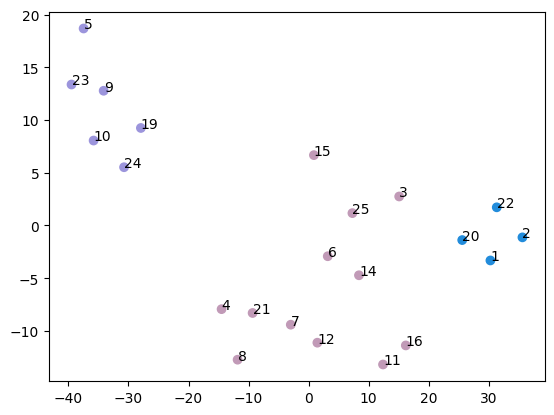

In [17]:
run_tsne(df_no_outliers[['spearman_{}'.format(l) for l in levels]].to_numpy(), labels=participants);
# run_tsne(df_no_outliers[['pearson_{}'.format(l) for l in levels]].to_numpy(), labels=participants);

### Use KMeans Color Labels in TSNE Plot

The average silhouette score for 2 clusters is 0.44
The average silhouette score for 3 clusters is 0.43
The average silhouette score for 4 clusters is 0.32


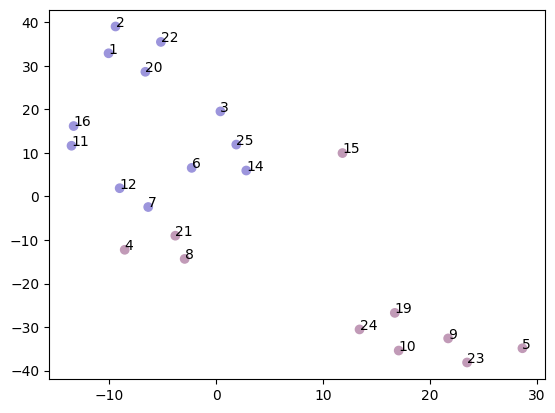

In [18]:
nclusters, cluster_arr, clusters = run_kmeans(df_no_outliers[['spearman_{}'.format(l) for l in levels]].to_numpy())
run_tsne(df_no_outliers[['spearman_{}'.format(l) for l in levels]].to_numpy(), labels=participants, clusters=cluster_arr);

In [19]:
clusters

{0: [4, 5, 8, 9, 10, 15, 19, 21, 23, 24],
 1: [1, 2, 3, 6, 7, 11, 12, 14, 16, 20, 22, 25]}

In [20]:
pp_clusters = {0: [22, 7, 16, 11, 8, 4, 12, 6, 14, 20, 1, 2], 1: [24, 9, 19, 3, 23, 10, 21, 5, 25, 15]}

In [21]:
print(set(clusters[0]).intersection(pp_clusters[0]), set(clusters[0]).intersection(pp_clusters[1]))
print(set(clusters[1]).intersection(pp_clusters[0]), set(clusters[1]).intersection(pp_clusters[1]))
print(set(clusters[2]).intersection(pp_clusters[0]), set(clusters[2]).intersection(pp_clusters[1]))

{8, 4} {5, 9, 10, 15, 19, 21, 23, 24}
{1, 2, 6, 7, 11, 12, 14, 16, 20, 22} {25, 3}


KeyError: 2

In [22]:
clusters

{0: [4, 5, 8, 9, 10, 15, 19, 21, 23, 24],
 1: [1, 2, 3, 6, 7, 11, 12, 14, 16, 20, 22, 25]}

In [23]:
df = correlations['rsivl'].iloc[[x-1 for x in participants]]
df["participant"] = df.index
pop1 = [3, 4, 6, 7, 8, 11, 12, 14, 15, 16, 21, 25]
pop2 = [5, 9, 10, 19, 23, 24]
pop3 = [1, 2, 20, 22]

/tmp/ipykernel_37761/130379549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["participant"] = df.index


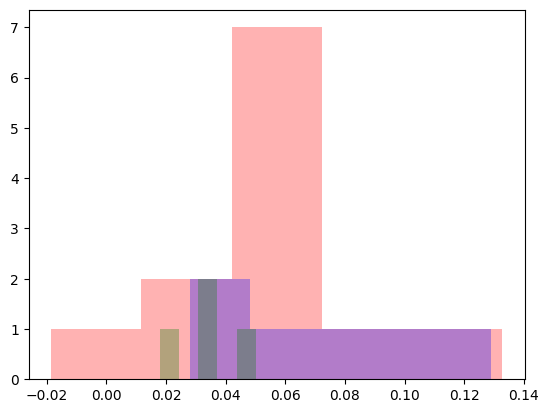

In [24]:
df1 = df[df['participant'].isin([x-1 for x in pop1])]
df2 = df[df['participant'].isin([x-1 for x in pop2])]
df3 = df[df['participant'].isin([x-1 for x in pop3])]
plt.hist(df1['spearman_64points']-df1['spearman_16points'], bins=5, color="red", alpha=0.3);
plt.hist(df2['spearman_64points']-df2['spearman_16points'], bins=5, color="blue", alpha=0.3);
plt.hist(df3['spearman_64points']-df3['spearman_16points'], bins=5, color="green", alpha=0.3);

In [25]:
correlations['rsivl'][['spearman_{}'.format(l) for l in levels]].iloc[
    [x-1 for x in pop1 + pop2 + pop3]]

,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
2,0.584475,0.645660,0.718293,0.712826,0.699775
3,0.347431,0.531623,0.564698,0.685483,0.697400
5,0.448184,0.562836,0.639317,0.687692,0.698355
6,0.376283,0.564168,0.638571,0.680657,0.704606
7,0.332908,0.523939,0.607780,0.641944,0.677241
10,0.415006,0.642285,0.697816,0.750747,0.765107
11,0.379822,0.604998,0.652971,0.701770,0.715255
13,0.462837,0.548496,0.681465,0.731693,0.738503
14,0.539811,0.542350,0.579919,0.613438,0.619819
15,0.420663,0.626573,0.724082,0.757683,0.784535


### Include the Outliers

The average silhouette score for 2 clusters is 0.80
The average silhouette score for 3 clusters is 0.50
The average silhouette score for 4 clusters is 0.44
The average silhouette score for 2 clusters is 0.80
The average silhouette score for 3 clusters is 0.50
The average silhouette score for 4 clusters is 0.42


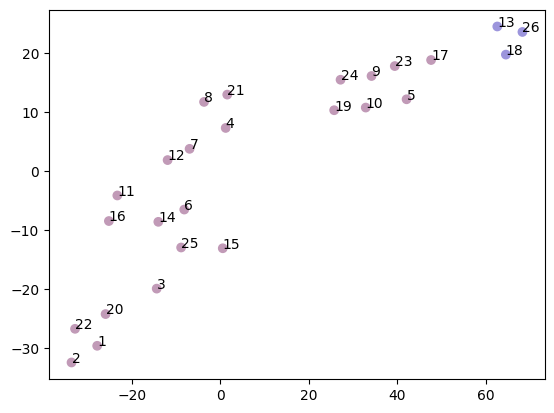

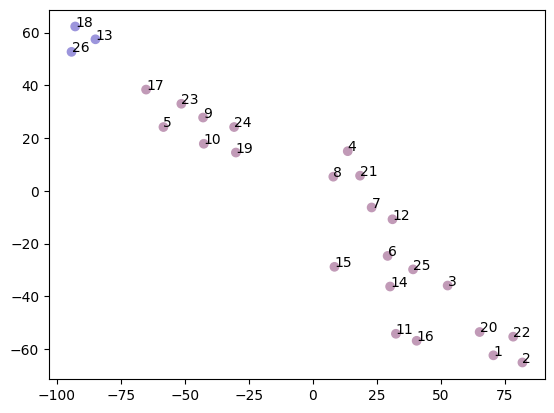

In [26]:
df = correlations['rsivl']
participants = list(range(1, 27))
run_tsne(df[['spearman_{}'.format(l) for l in levels]].to_numpy(), labels=participants);
nclusters, cluster_arr, clusters = run_kmeans(df[['spearman_{}'.format(l) for l in levels]].to_numpy())
run_tsne(df[['spearman_{}'.format(l) for l in levels]].to_numpy(), labels=participants, clusters=cluster_arr);

## VISC

In [27]:
df_no_outliers = correlations['visc'][~correlations['visc'].index.isin([i-1 for i in [7, 14, 28]])]
participants = list(range(1, 41))
participants = [x for x in participants if x not in [7, 14, 28]]

The average silhouette score for 2 clusters is 0.47
The average silhouette score for 3 clusters is 0.38
The average silhouette score for 4 clusters is 0.41


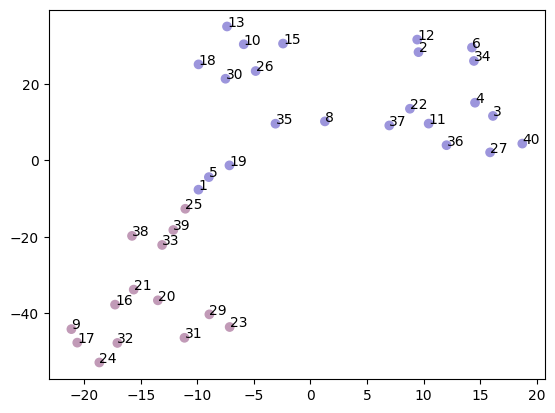

In [31]:
run_tsne(df_no_outliers[['spearman_{}'.format(l) for l in levels]].to_numpy(), labels=participants);

### Use KMeans Color Labels in TSNE Plot

The average silhouette score for 2 clusters is 0.47
The average silhouette score for 3 clusters is 0.39
The average silhouette score for 4 clusters is 0.40


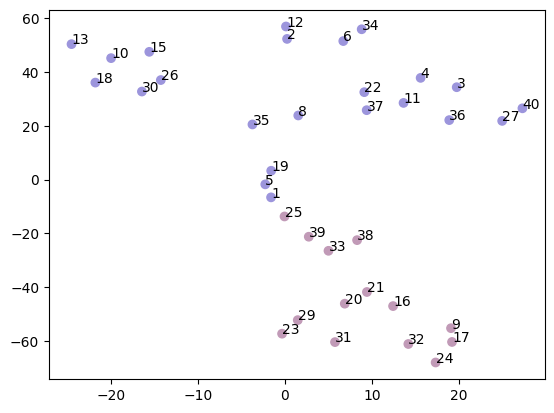

In [32]:
nclusters, cluster_arr, clusters = run_kmeans(df_no_outliers[['spearman_{}'.format(l) for l in levels]].to_numpy())
run_tsne(df_no_outliers[['spearman_{}'.format(l) for l in levels]].to_numpy(), labels=participants, clusters=cluster_arr);

In [33]:
print(clusters)
df = correlations['visc'].iloc[[x-1 for x in participants]]
df["participant"] = df.index
pop1 = [2, 3, 4, 6, 8, 10, 11, 12, 13, 15, 18, 22, 26, 27, 30, 34, 35, 36, 37, 40]
pop2 = [9, 16, 17, 20, 21, 23, 24, 29, 31, 32]
pop3 = [33, 38, 39, 25, 1, 5, 19]

{0: [9, 16, 17, 20, 21, 23, 24, 25, 29, 31, 32, 33, 38, 39], 1: [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 15, 18, 19, 22, 26, 27, 30, 34, 35, 36, 37, 40]}


/tmp/ipykernel_37761/2256925632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["participant"] = df.index


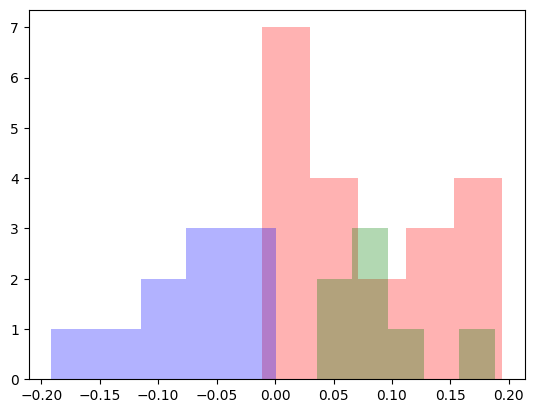

In [34]:
df1 = df[df['participant'].isin([x-1 for x in pop1])]
df2 = df[df['participant'].isin([x-1 for x in pop2])]
df3 = df[df['participant'].isin([x-1 for x in pop3])]
plt.hist(df1['spearman_64points']-df1['spearman_16points'], bins=5, color="red", alpha=0.3);
plt.hist(df2['spearman_64points']-df2['spearman_16points'], bins=5, color="blue", alpha=0.3);
plt.hist(df3['spearman_64points']-df3['spearman_16points'], bins=5, color="green", alpha=0.3);

In [35]:
correlations['visc'][['spearman_{}'.format(l) for l in levels]].iloc[[x-1 for x in pop1]].describe()

,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.057102,0.188344,0.317921,0.376697,0.394066
std,0.131122,0.135171,0.089450,0.077696,0.084059
min,-0.222841,-0.150595,0.092572,0.190335,0.245625
25%,-0.003943,0.082932,0.269138,0.307118,0.316697
50%,0.084461,0.218686,0.322790,0.400887,0.414417
75%,0.161080,0.277261,0.382264,0.432223,0.449023
max,0.236851,0.359511,0.445052,0.488111,0.538499


In [36]:
correlations['visc'][['spearman_{}'.format(l) for l in levels]].iloc[[x-1 for x in pop2]].describe()

,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.445251,0.561686,0.624164,0.602192,0.551848
std,0.107050,0.096823,0.071290,0.073140,0.076974
min,0.317755,0.453937,0.516307,0.458629,0.410517
25%,0.360869,0.482353,0.591960,0.556790,0.502524
50%,0.438066,0.544326,0.607699,0.620556,0.580894
75%,0.490016,0.624864,0.674255,0.650218,0.605764
max,0.683730,0.754984,0.737387,0.696159,0.644819


In [37]:
correlations['visc'][['spearman_{}'.format(l) for l in levels]].iloc[[x-1 for x in pop3]].describe()

,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.107181,0.307706,0.527847,0.597791,0.618443
std,0.082484,0.075546,0.052221,0.043497,0.048046
min,0.007300,0.220516,0.450911,0.532949,0.542002
25%,0.047361,0.236369,0.496750,0.579636,0.588973
50%,0.073698,0.324952,0.533801,0.587795,0.638846
75%,0.178279,0.366386,0.557353,0.615925,0.646153
max,0.217987,0.402968,0.602012,0.672673,0.678000


In [39]:
correlations['visc'][['spearman_{}'.format(l) for l in levels]].iloc[
    [x-1 for x in pop2 + pop1 + pop3]]

,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
8,0.425774,0.631434,0.702565,0.696159,0.644819
15,0.378777,0.514172,0.612680,0.639810,0.611225
16,0.479594,0.625611,0.675477,0.660289,0.609301
19,0.354900,0.469286,0.589476,0.611791,0.590624
20,0.317755,0.479541,0.599412,0.619627,0.595153
22,0.450358,0.453937,0.516307,0.458629,0.410517
23,0.683730,0.754984,0.737387,0.653688,0.545890
28,0.352623,0.490789,0.535030,0.521991,0.488068
30,0.493490,0.574481,0.602719,0.538457,0.451722
31,0.515510,0.622626,0.670589,0.621484,0.571164


## Cluster based on Model Correlation Diffs

In [231]:
df = pd.DataFrame(correlations['rsivl']['spearman_4points'])

for i in range(1, len(levels)):
    df["{}-{}".format(levels[i], levels[i-1])] = correlations['rsivl']['spearman_{}'.format(levels[i])]-correlations['rsivl']['spearman_{}'.format(levels[i-1])]

In [232]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]
df2 = df[df.index.isin([i-1 for i in participants])]

The average silhouette score for 2 clusters is 0.42
The average silhouette score for 3 clusters is 0.35
The average silhouette score for 4 clusters is 0.31
The average silhouette score for 2 clusters is 0.41
The average silhouette score for 3 clusters is 0.23
The average silhouette score for 4 clusters is 0.36


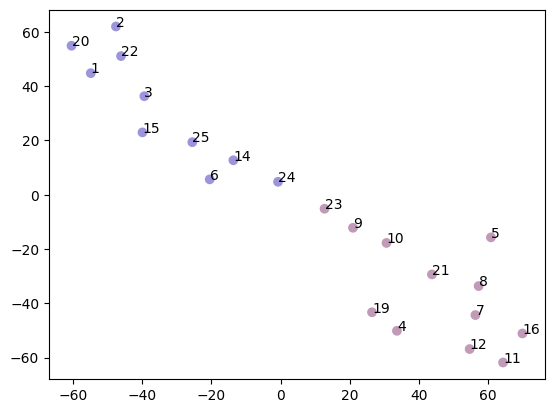

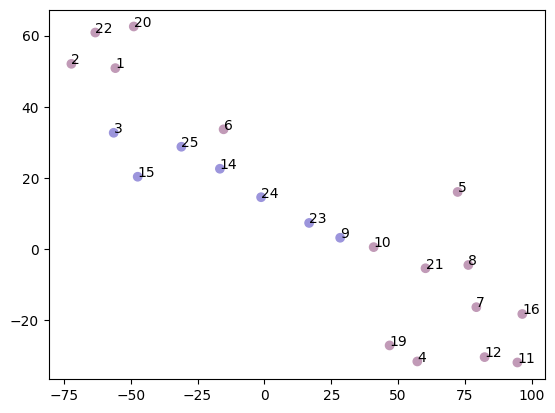

In [233]:
run_tsne(df2[df2.columns[0:]].to_numpy(), labels=participants);
nclusters, cluster_arr, clusters = run_kmeans(df2[df2.columns[1:]].to_numpy())
run_tsne(df2[df2.columns[0:]].to_numpy(), labels=participants, clusters=cluster_arr);

The average silhouette score for 2 clusters is 0.41
The average silhouette score for 3 clusters is 0.34
The average silhouette score for 4 clusters is 0.35
The average silhouette score for 2 clusters is 0.41
The average silhouette score for 3 clusters is 0.34
The average silhouette score for 4 clusters is 0.25


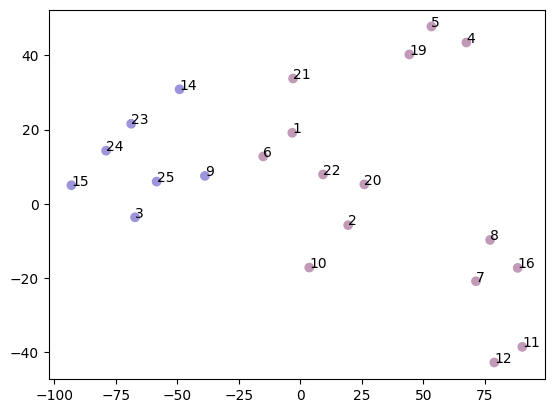

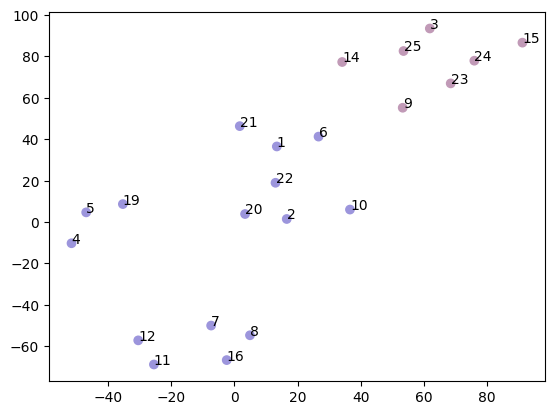

In [234]:
run_tsne(df2[df2.columns[1:]].to_numpy(), labels=participants);
nclusters, cluster_arr, clusters = run_kmeans(df2[df2.columns[1:]].to_numpy())
run_tsne(df2[df2.columns[1:]].to_numpy(), labels=participants, clusters=cluster_arr);

The average silhouette score for 2 clusters is 0.31
The average silhouette score for 3 clusters is 0.26
The average silhouette score for 4 clusters is 0.32
The average silhouette score for 2 clusters is 0.41
The average silhouette score for 3 clusters is 0.34
The average silhouette score for 4 clusters is 0.36


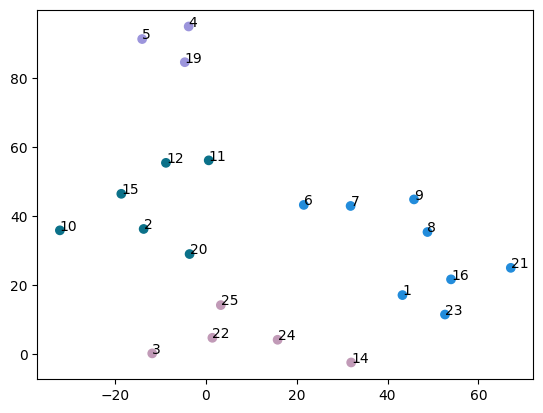

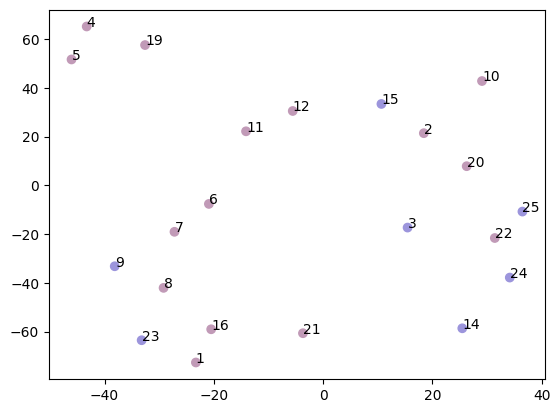

In [235]:
run_tsne(df2[df2.columns[2:]].to_numpy(), labels=participants);
nclusters, cluster_arr, clusters = run_kmeans(df2[df2.columns[1:]].to_numpy())
run_tsne(df2[df2.columns[2:]].to_numpy(), labels=participants, clusters=cluster_arr);

The average silhouette score for 2 clusters is 0.56
The average silhouette score for 3 clusters is 0.45
The average silhouette score for 4 clusters is 0.40
The average silhouette score for 2 clusters is 0.41
The average silhouette score for 3 clusters is 0.29
The average silhouette score for 4 clusters is 0.36


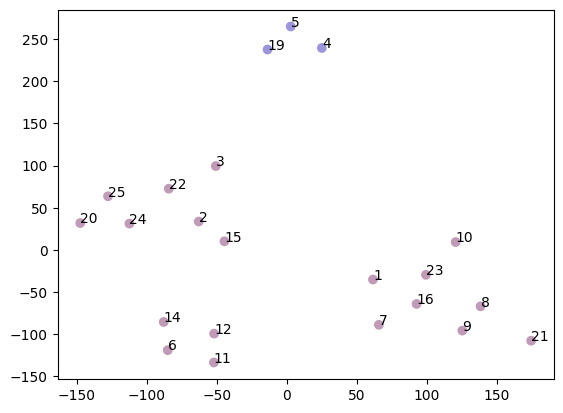

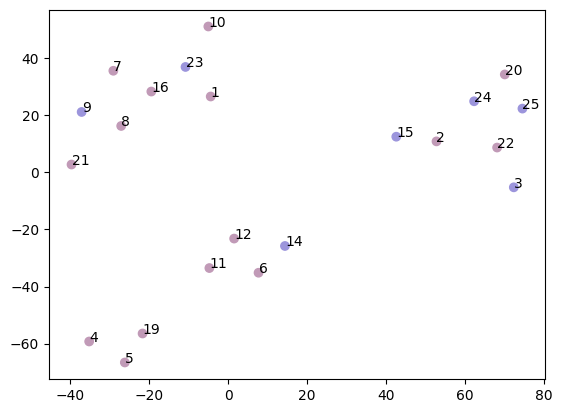

In [256]:
run_tsne(df2[df2.columns[3:]].to_numpy(), labels=participants, clusters_to_check=range(2,5));
nclusters, cluster_arr, clusters = run_kmeans(df2[df2.columns[1:]].to_numpy())
run_tsne(df2[df2.columns[3:]].to_numpy(), labels=participants, clusters=cluster_arr);

## Plot Correlation vs Granularity

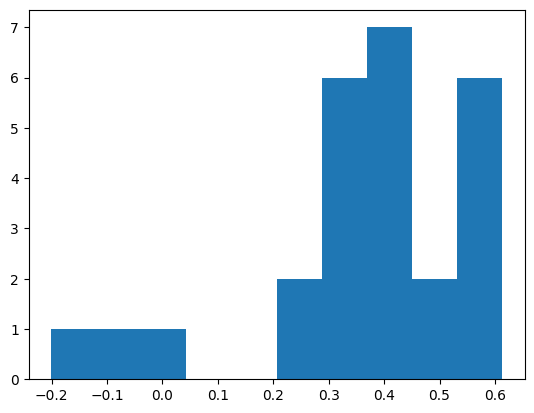

In [50]:
plt.hist(correlations['rsivl']['spearman_4points'], bins=10);

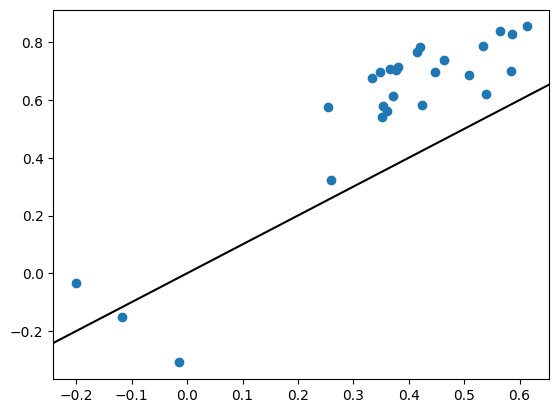

In [51]:
plt.scatter(correlations['rsivl']['spearman_4points'], correlations['rsivl']['spearman_64points']);
plt.axline((0, 0), slope=1, color='black')

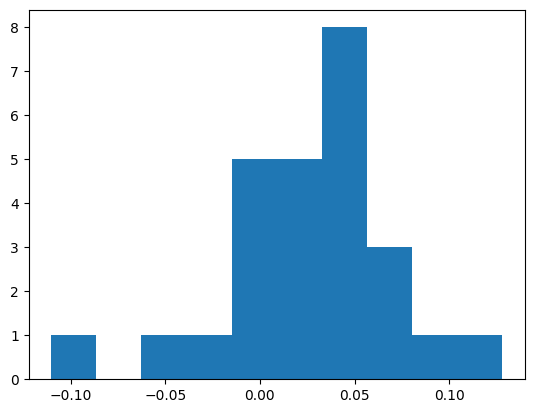

In [93]:
plt.hist(correlations['rsivl']['pearson_64points']-correlations['rsivl']['pearson_16points'], bins=10);

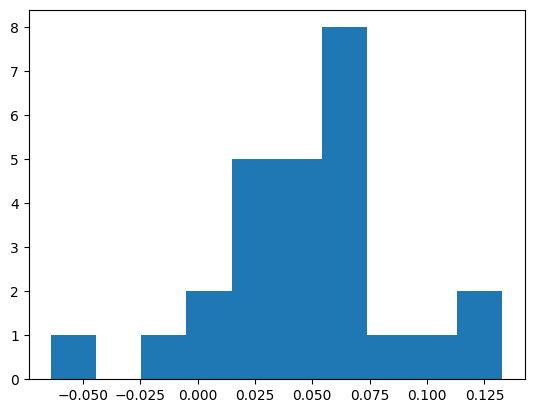

In [88]:
plt.hist(correlations['rsivl']['spearman_64points']-correlations['rsivl']['spearman_16points'], bins=10);

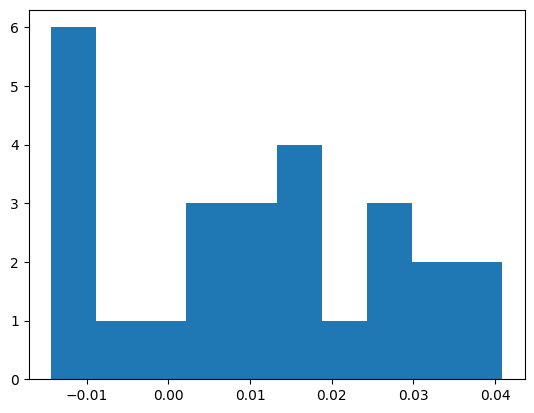

In [89]:
plt.hist(correlations['rsivl']['spearman_64points']-correlations['rsivl']['spearman_32points'], bins=10);

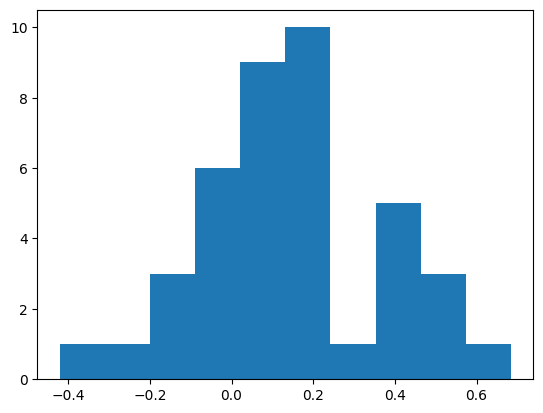

In [45]:
plt.hist(correlations['visc']['spearman_4points'], bins=10);

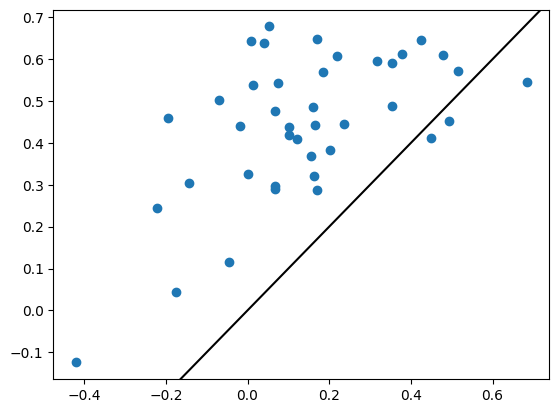

In [49]:
plt.scatter(correlations['visc']['spearman_4points'], correlations['visc']['spearman_64points']);
plt.axline((0, 0), slope=1, color='black')

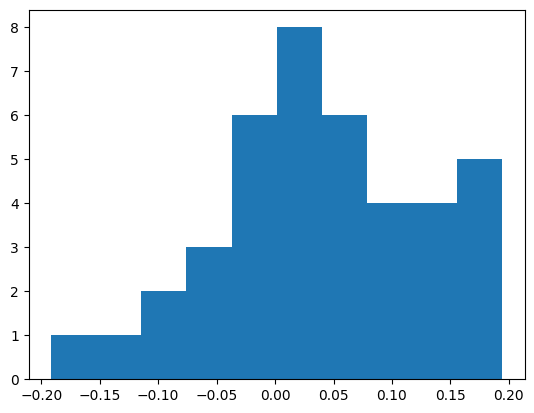

In [87]:
plt.hist(correlations['visc']['spearman_64points']-correlations['visc']['spearman_16points'], bins=10);

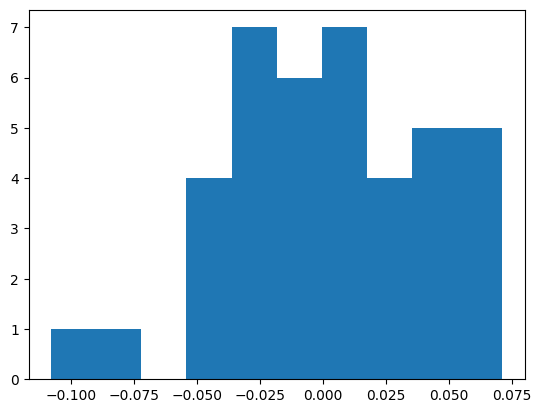

In [118]:
plt.hist(correlations['visc']['spearman_64points']-correlations['visc']['spearman_32points'], bins=10);

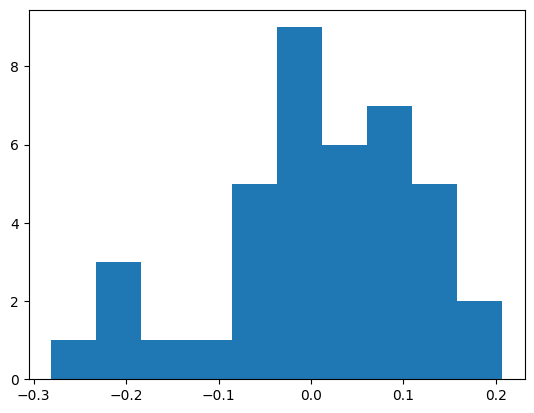

In [122]:
plt.hist(correlations['visc']['pearson_64points']-correlations['visc']['pearson_16points'], bins=10);

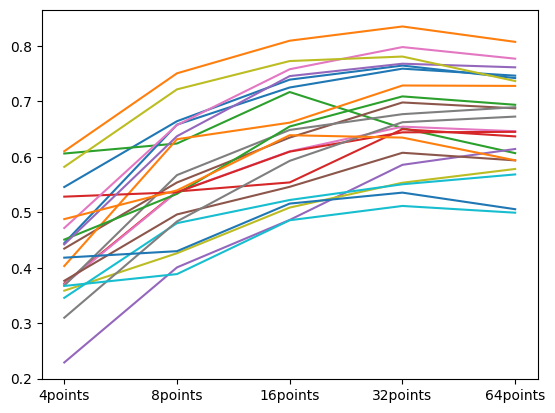

In [46]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]

for i in participants:
    plt.plot(levels, correlations['rsivl'].iloc[[i-1]][["pearson_{}".format(l) for l in levels]].to_numpy().squeeze())

In [47]:
df = pd.DataFrame(correlations['rsivl']['pearson_4points'])

for i in range(1, len(levels)):
    df["{}-{}".format(levels[i], levels[i-1])] = correlations['rsivl']['pearson_{}'.format(levels[i])]-correlations['rsivl']['pearson_{}'.format(levels[i-1])]

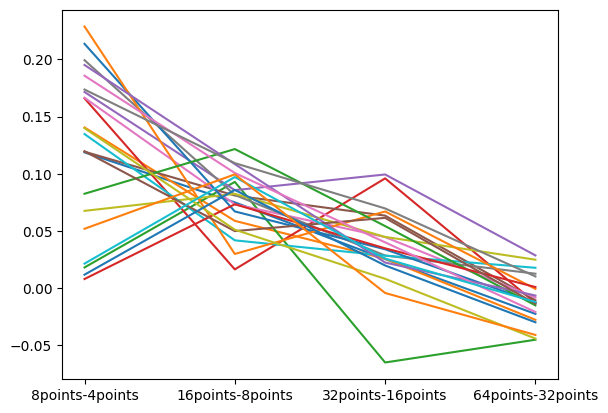

In [48]:
for i in participants:
    labels = ["{}-{}".format(levels[k], levels[k-1]) for k in range(1, len(levels))]
    plt.plot(labels, df.iloc[[i-1]][labels].to_numpy().squeeze())

### Spearman

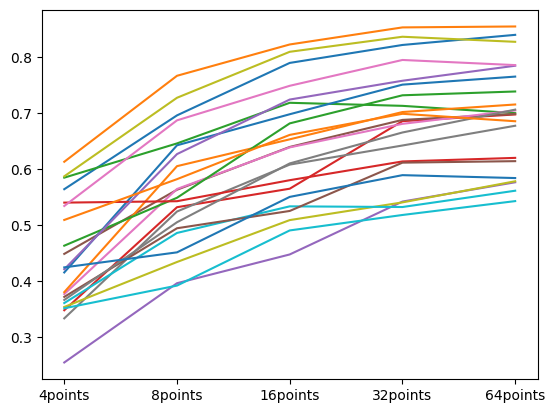

In [49]:
for i in participants:
    plt.plot(levels, correlations['rsivl'].iloc[[i-1]][["spearman_{}".format(l) for l in levels]].to_numpy().squeeze())

In [50]:
df = pd.DataFrame(correlations['rsivl']['spearman_4points'])

for i in range(1, len(levels)):
    df["{}-{}".format(levels[i], levels[i-1])] = correlations['rsivl']['spearman_{}'.format(levels[i])]-correlations['rsivl']['spearman_{}'.format(levels[i-1])]

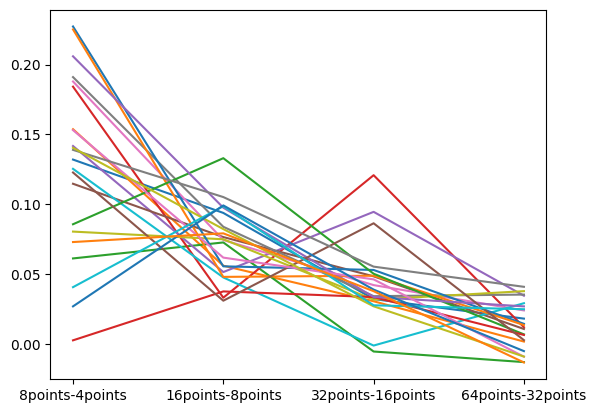

In [51]:
for i in participants:
    labels = ["{}-{}".format(levels[k], levels[k-1]) for k in range(1, len(levels))]
    plt.plot(labels, df.iloc[[i-1]][labels].to_numpy().squeeze())

# Clustering Participants based on Ratings

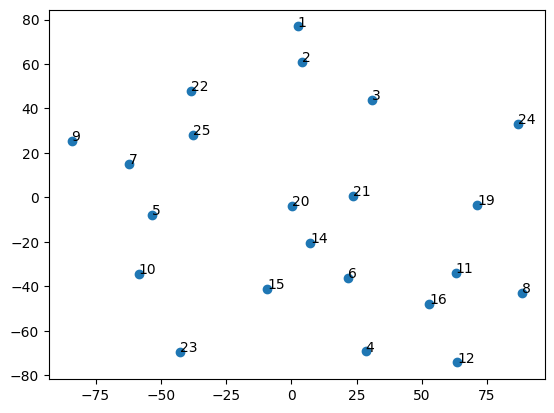

In [52]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]
X = data['rsivl'][["participant{}".format(i) for i in participants]].to_numpy().swapaxes(1, 0)
run_tsne(X, labels=participants)

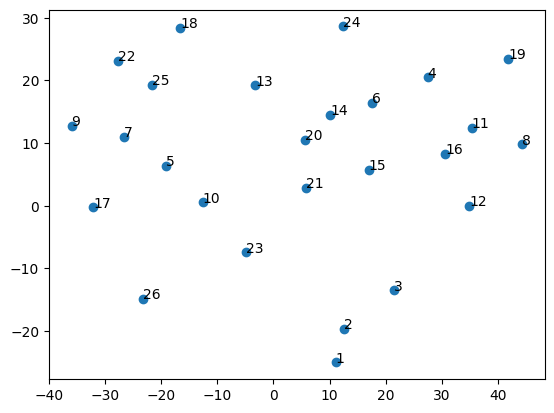

In [53]:
participants = list(range(1, 27))
X = data['rsivl'][["participant{}".format(i) for i in participants]].to_numpy().swapaxes(1, 0)
run_tsne(X, labels=participants)

# Clustering based on Participant-Participant Correlations

In [54]:
# based on https://www.kaggle.com/code/sgalella/correlation-heatmaps-with-hierarchical-clustering

In [55]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]
participant_correlations = {}
df = data['rsivl'][['participant{}'.format(i) for i in participants]]
participant_correlations['pearson'] = df.corr(method='pearson')
participant_correlations['spearman'] = df.corr(method='spearman')

In [56]:
import seaborn as sns

<Axes: >

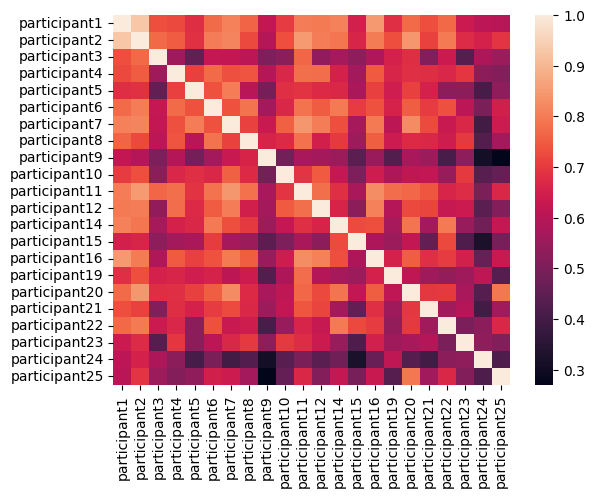

In [57]:
sns.heatmap(participant_correlations['spearman'])

<Axes: >

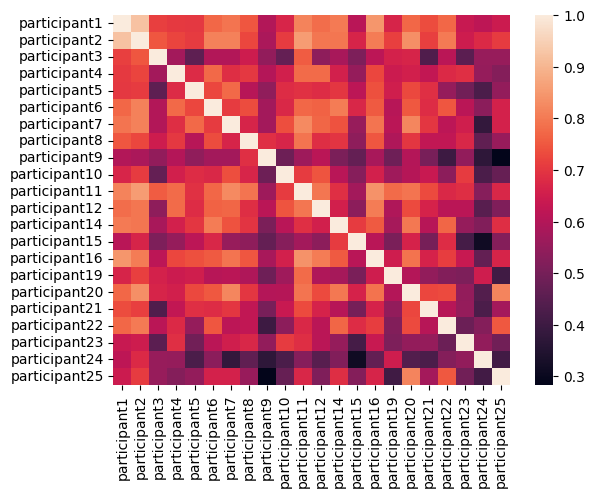

In [58]:
sns.heatmap(participant_correlations['pearson'])

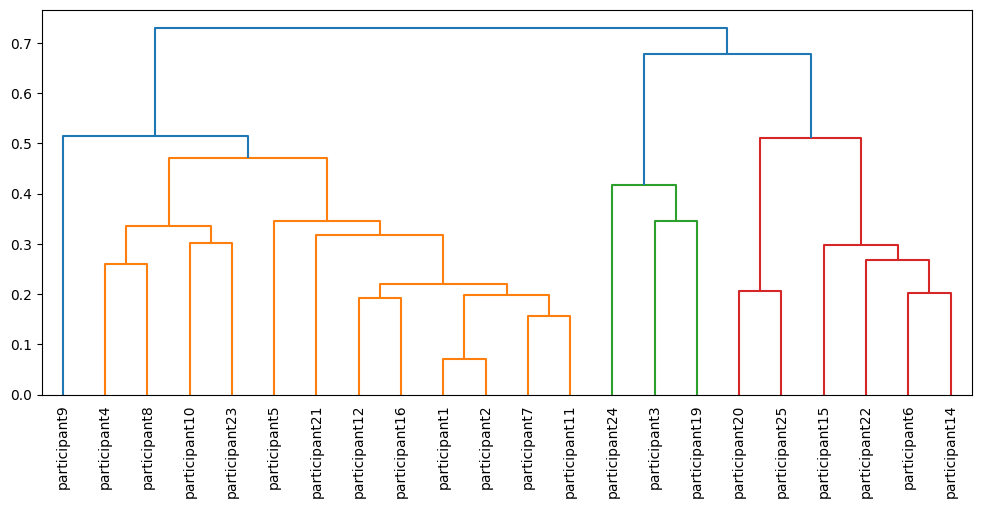

In [59]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(participant_correlations['spearman'])
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=df.columns, orientation='top', 
           leaf_rotation=90);

In [60]:
# Clusterize the data
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [61]:
# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(df.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df[i])
    else:
        df_to_append = pd.DataFrame(df[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

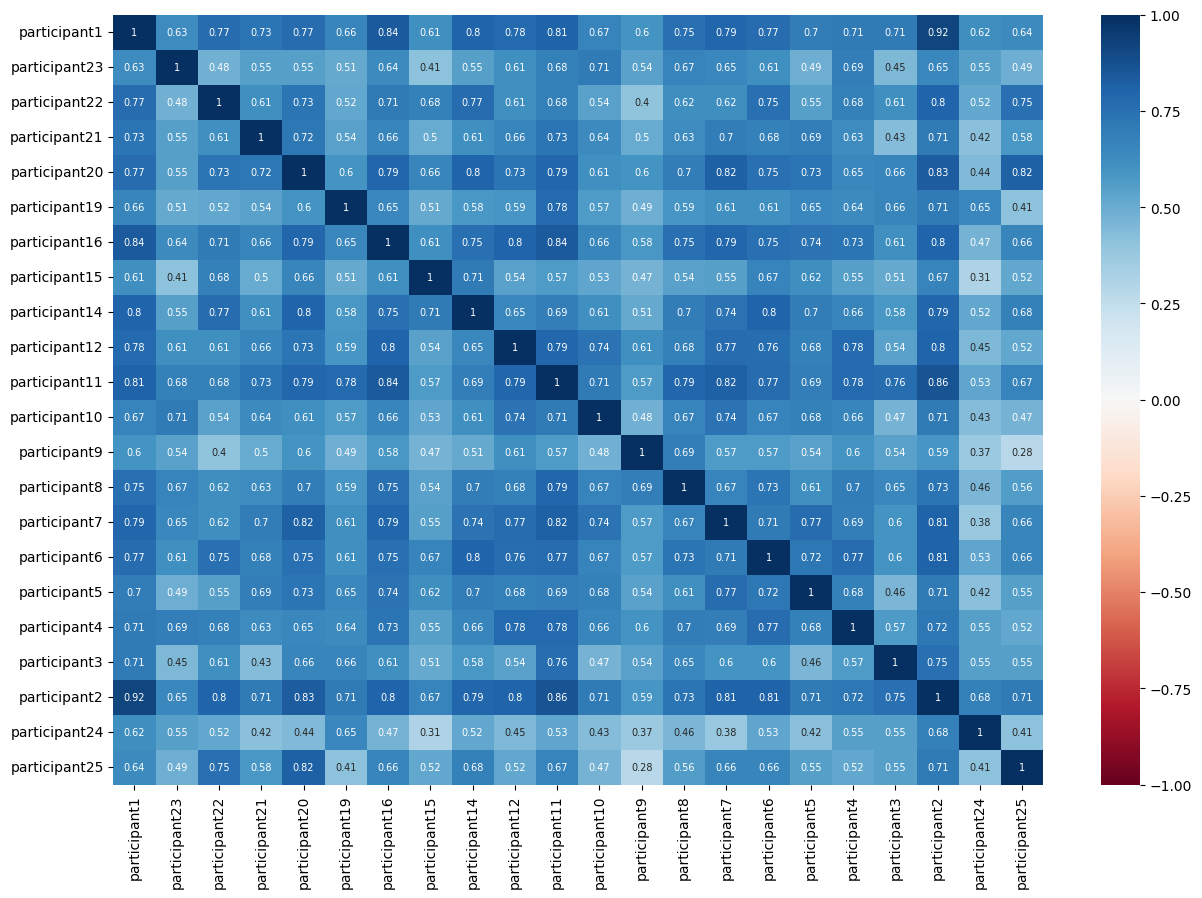

In [62]:
plt.figure(figsize=(15,10))
correlations_heatmap = clustered.corr()
sns.heatmap(round(correlations_heatmap,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=-1, vmax=1);

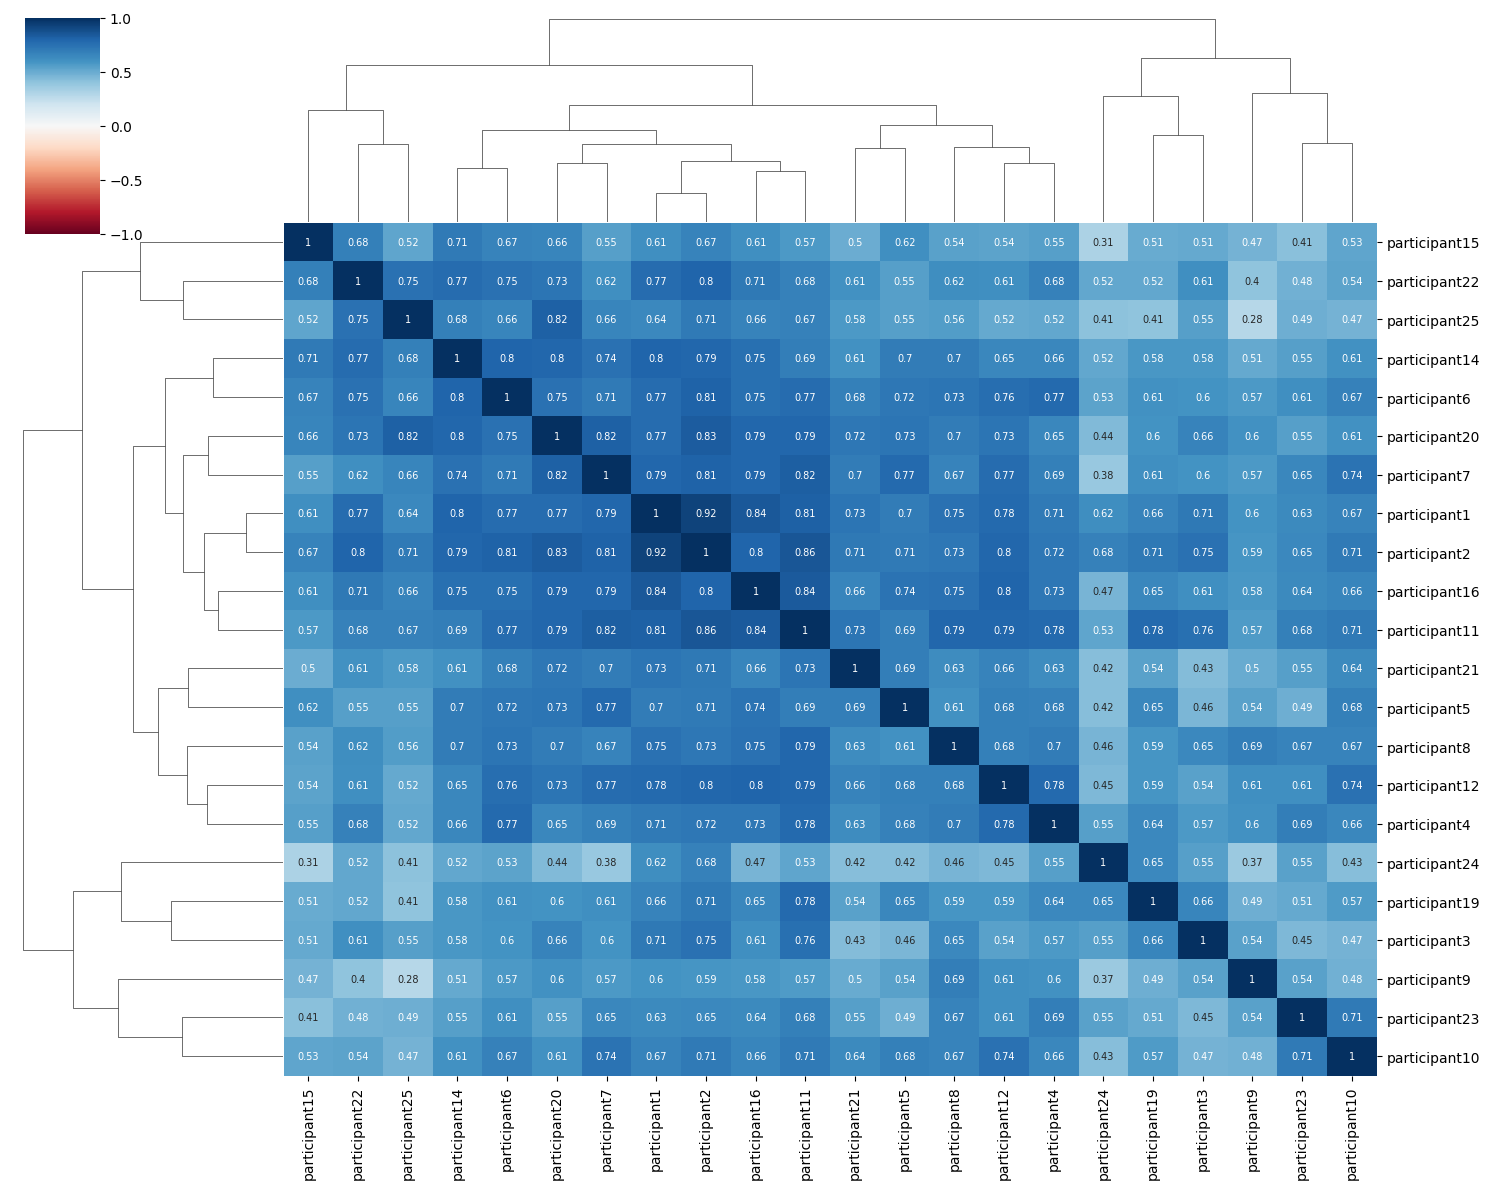

In [63]:
sns.clustermap(correlations_heatmap, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));

## Do Participants with Similary Ratings have Similar Model Correlations?

In [ ]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]
df = correlations['rsivl'].iloc[[x-1 for x in participants]]

In [77]:
df["participant"] = df.index
pop1 = [22, 7, 16, 11, 8, 4, 12, 6, 14, 20, 1, 2]
pop2 = [24, 9, 19, 3, 23, 10, 21, 5, 25, 15]

/tmp/ipykernel_22242/1546673517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["participant"] = df.index;


In [82]:
correlations['rsivl'][['spearman_{}'.format(l) for l in levels]].iloc[
    [x-1 for x in pop1 + pop2]]

,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
21,0.586870,0.727263,0.809457,0.836361,0.827288
6,0.376283,0.564168,0.638571,0.680657,0.704606
15,0.420663,0.626573,0.724082,0.757683,0.784535
10,0.415006,0.642285,0.697816,0.750747,0.765107
7,0.332908,0.523939,0.607780,0.641944,0.677241
3,0.347431,0.531623,0.564698,0.685483,0.697400
11,0.379822,0.604998,0.652971,0.701770,0.715255
5,0.448184,0.562836,0.639317,0.687692,0.698355
13,0.462837,0.548496,0.681465,0.731693,0.738503
19,0.533827,0.686892,0.748661,0.794844,0.785670


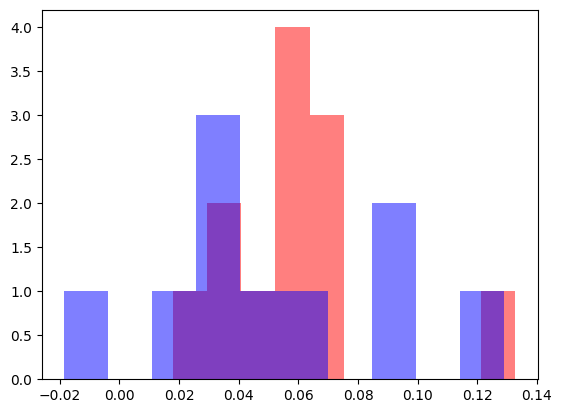

In [86]:
df1 = df[df['participant'].isin([x-1 for x in pop1])]
df2 = df[df['participant'].isin([x-1 for x in pop2])]
plt.hist(df1['spearman_64points']-df1['spearman_16points'], bins=10, color="red", alpha=0.5);
plt.hist(df2['spearman_64points']-df2['spearman_16points'], bins=10, color="blue", alpha=0.5);

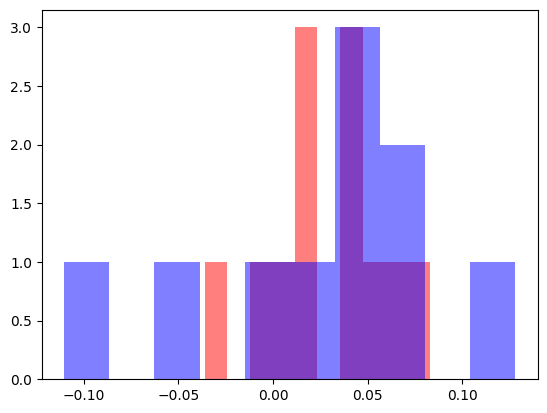

In [81]:
df1 = df[df['participant'].isin([x-1 for x in pop1])]
df2 = df[df['participant'].isin([x-1 for x in pop2])]
plt.hist(df1['pearson_64points']-df1['pearson_16points'], bins=10, color="red", alpha=0.5);
plt.hist(df2['pearson_64points']-df2['pearson_16points'], bins=10, color="blue", alpha=0.5);

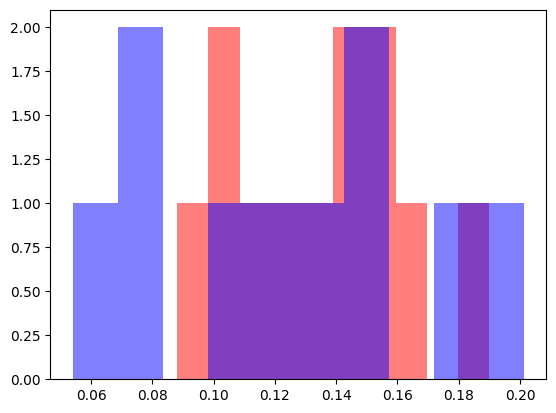

In [74]:
df1 = df[df['participant'].isin([x-1 for x in pop1])]
df2 = df[df['participant'].isin([x-1 for x in pop2])]
plt.hist(df1['spearman_64points']-df1['spearman_8points'], bins=10, color="red", alpha=0.5);
plt.hist(df2['spearman_64points']-df2['spearman_8points'], bins=10, color="blue", alpha=0.5);

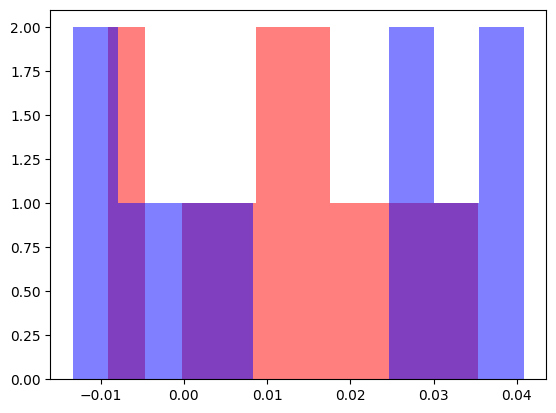

In [76]:
df1 = df[df['participant'].isin([x-1 for x in pop1])]
df2 = df[df['participant'].isin([x-1 for x in pop2])]
plt.hist(df1['spearman_64points']-df1['spearman_32points'], bins=10, color="red", alpha=0.5);
plt.hist(df2['spearman_64points']-df2['spearman_32points'], bins=10, color="blue", alpha=0.5);

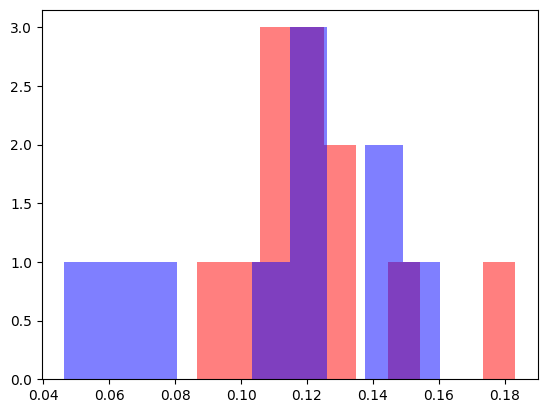

In [84]:
df1 = df[df['participant'].isin([x-1 for x in pop1])]
df2 = df[df['participant'].isin([x-1 for x in pop2])]
plt.hist(df1['spearman_32points']-df1['spearman_8points'], bins=10, color="red", alpha=0.5);
plt.hist(df2['spearman_32points']-df2['spearman_8points'], bins=10, color="blue", alpha=0.5);

## VISC

In [ ]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]
participant_correlations = {}
df = data['rsivl'][['participant{}'.format(i) for i in participants]]


In [93]:
overlap_sets = []

for i in range(1, 41):
    for j in range(1, 41):
        flags = (~data['visc']['participant{}'.format(i)].isna()) & (~data['visc']['participant{}'.format(j)].isna())
        count = sum(flags)
        if count > 0:
            overlap_sets.append(data['visc'][flags])
        print("Overlap participants: {}, {} is {}".format(i, j, count))

Overlap participants: 1, 1 is 200
Overlap participants: 1, 2 is 0
Overlap participants: 1, 3 is 0
Overlap participants: 1, 4 is 0
Overlap participants: 1, 5 is 100
Overlap participants: 1, 6 is 100
Overlap participants: 1, 7 is 100
Overlap participants: 1, 8 is 0
Overlap participants: 1, 9 is 0
Overlap participants: 1, 10 is 100
Overlap participants: 1, 11 is 100
Overlap participants: 1, 12 is 100
Overlap participants: 1, 13 is 200
Overlap participants: 1, 14 is 0
Overlap participants: 1, 15 is 0
Overlap participants: 1, 16 is 0
Overlap participants: 1, 17 is 0
Overlap participants: 1, 18 is 200
Overlap participants: 1, 19 is 100
Overlap participants: 1, 20 is 100
Overlap participants: 1, 21 is 100
Overlap participants: 1, 22 is 0
Overlap participants: 1, 23 is 0
Overlap participants: 1, 24 is 0
Overlap participants: 1, 25 is 200
Overlap participants: 1, 26 is 0
Overlap participants: 1, 27 is 100
Overlap participants: 1, 28 is 0
Overlap participants: 1, 29 is 0
Overlap participants: 1,

In [94]:
image_sets = set()

In [95]:
for os in overlap_sets:
    s = set(os['filename'].unique())
    if len(s) == 100:
        image_sets.add(tuple(sorted(list(s))))

In [72]:
s1 = set(overlap_sets[0]['filename'].unique()).intersection(set(overlap_sets[1]['filename'].unique()))
s2 = set(overlap_sets[0]['filename'].unique()) - set(overlap_sets[1]['filename'].unique())

In [74]:
for i in range(1, 41):
    s = set(data['visc'][~data['visc']['participant{}'.format(i)].isna()]['filename'].unique()).intersection(s1)
    count = len(s)
    print("Overlap participant {} and s1 is {}".format(i, count))

Overlap participant 1 and s1 is 100
Overlap participant 2 and s1 is 0
Overlap participant 3 and s1 is 0
Overlap participant 4 and s1 is 0
Overlap participant 5 and s1 is 100
Overlap participant 6 and s1 is 100
Overlap participant 7 and s1 is 100
Overlap participant 8 and s1 is 0
Overlap participant 9 and s1 is 0
Overlap participant 10 and s1 is 0
Overlap participant 11 and s1 is 100
Overlap participant 12 and s1 is 0
Overlap participant 13 and s1 is 100
Overlap participant 14 and s1 is 0
Overlap participant 15 and s1 is 0
Overlap participant 16 and s1 is 0
Overlap participant 17 and s1 is 0
Overlap participant 18 and s1 is 100
Overlap participant 19 and s1 is 0
Overlap participant 20 and s1 is 0
Overlap participant 21 and s1 is 100
Overlap participant 22 and s1 is 0
Overlap participant 23 and s1 is 0
Overlap participant 24 and s1 is 0
Overlap participant 25 and s1 is 100
Overlap participant 26 and s1 is 0
Overlap participant 27 and s1 is 0
Overlap participant 28 and s1 is 0
Overlap par

In [104]:
pop1 = [9, 16, 17, 20, 21, 23, 24, 29, 31, 32]
pop2 = [2, 3, 4, 6, 8, 10, 11, 12, 13, 15, 18, 22, 26, 27, 30, 34, 35, 36, 37, 40, 33, 38, 39, 25, 1, 5, 19]
image_sets_list = list(image_sets)

In [105]:
pop1_image_set_distrib = np.zeros(len(image_sets_list))

for i in pop1:
    for k, si in enumerate(image_sets_list):
        s = set(data['visc'][~data['visc']['participant{}'.format(i)].isna()]['filename'].unique()).intersection(si)
        if len(s) == 100:
            pop1_image_set_distrib[k] += 1

In [106]:
pop1_image_set_distrib

array([1., 5., 1., 3., 0., 1., 3., 6.])

In [107]:
pop2_image_set_distrib = np.zeros(len(image_sets_list))

for i in pop2:
    for k, si in enumerate(image_sets_list):
        s = set(data['visc'][~data['visc']['participant{}'.format(i)].isna()]['filename'].unique()).intersection(si)
        if len(s) == 100:
            pop2_image_set_distrib[k] += 1

In [108]:
pop2_image_set_distrib

array([9., 4., 8., 6., 9., 8., 6., 4.])

In [119]:
class_corr = {}

for i, si in enumerate(image_sets_list):
    df = data['visc'][data['visc']['filename'].isin(si)]
    
    class_corr[i+1] = {'spearman': [], 'pearson': []}

    for l in levels:
        class_corr[i+1]['spearman'].append(stats.spearmanr(df[l], df["complexity"]).statistic)
        class_corr[i+1]['pearson'].append(stats.pearsonr(df[l], df["complexity"]).statistic)

In [120]:
class_corr

{1: {'spearman': [-0.10813916868557505,
   0.1752245369390595,
   0.5572305478712614,
   0.6509942668136683,
   0.6811371990864816],
  'pearson': [-0.09506986929610216,
   0.18797408761117432,
   0.5595232191231934,
   0.6536400457162324,
   0.6848821855603552]},
 2: {'spearman': [0.4088436947671431,
   0.5969667431553762,
   0.6467316958363573,
   0.6494017851512867,
   0.5972093869360487],
  'pearson': [0.3757151594134337,
   0.6024762058393465,
   0.6594208459268587,
   0.6222477067412049,
   0.5591388093451772]},
 3: {'spearman': [0.16988758704969567,
   0.3572316926036011,
   0.6090464079773259,
   0.7100964849357198,
   0.7274320363576645],
  'pearson': [0.1360832332533812,
   0.35602288257253156,
   0.6040375479084167,
   0.6878011647131964,
   0.7006055413879481]},
 4: {'spearman': [0.2348157991430016,
   0.4127708343738516,
   0.5819933345482747,
   0.6208959943641656,
   0.6106528280817254],
  'pearson': [0.2416645418126729,
   0.3843029485752378,
   0.5685375664317995,
   0.